In [145]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

In [146]:
# number of article headlines displayed per ticker
n = 50
# assign ticker to view
tickers = ['tsla']

In [147]:
# scrape data from finviz with beautiful soup and requests
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}
# parse the URL for the HTML tables of news
for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table
# iterate through tickers to gather recent headlines
try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for tsla: 
28 Barrons Roundtable Picks to Beat the Market ( Jan-22-21 09:48PM )
GM and Ford Stock Finally Capture Some of Teslas Heat. Why This Is Only the Beginning. ( 08:23PM )
Old Car Brands Emerge in a New Packaging to Compete in a World Fixated on Tesla ( 08:13PM )
Elon Musk's SpaceX plans natural-gas drilling in Texas: report ( 05:14PM )
EVgo Is Merging With a SPAC to Go Public ( 05:03PM )
Tesla's too high to buy now; Beyond Meat perking up; GameStop shorts feeling pain: veteran trader ( 04:39PM )
Stock Market Rally Powers To Highs As Netflix, Apple Lead Big Tech Rally; Tesla Model Y Launches In China: Weekly Review ( 04:20PM )
Teslas 2021 sales goals is focus for car makers fourth-quarter earnings ( 01:52PM )
Tesla Is Shaking Up One of the Hottest Areas in Solar Power ( 12:55PM )
Tesla's Musk Offers $100M Reward for Best Carbon-Capture Tech ( 12:45PM )
Dow Slides As Pelosi Gets Set To Trigger Trump Impeachment; Microsoft Passes Buy Point ( 12:14PM )
How E

In [148]:
# hold parsed news into a list
parsed_news = []
# iterate through the news
for file_name, news_table in news_tables.items():
    # iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from the tr tag into text
        text = x.a.get_text() 
        # split the text in the td tag into a list
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' with the only element
        # if not, load 'date' with the 1st element and 'time' with the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # extract the ticker from the file name, get the string up to the 1st '_' 
        ticker = file_name.split('_')[0]
        # append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])


In [149]:
# nltk vader for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# new words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# update the lexicon
vader.lexicon.update(new_words)

In [150]:
# use these column names
columns = ['ticker', 'date', 'time', 'headline']
# convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline]
# convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
scored_news.columns = columns
# join the dataFrames
scored_news = scored_news.join(scores_df)
# convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

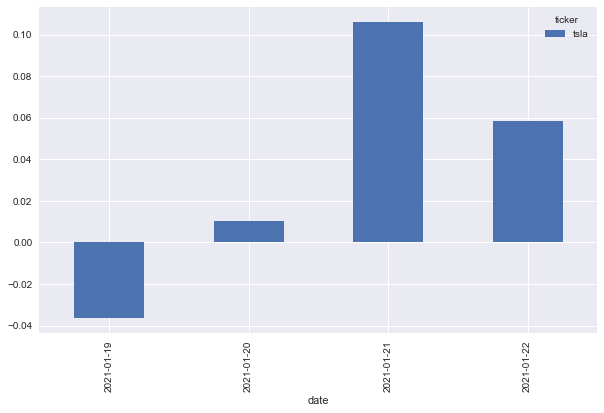

In [151]:
# group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date','ticker']).mean()
# unstack the column ticker
mean_c = mean_c.unstack('ticker')
# get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis='columns')
# plot a bar chart with pandas
mean_c.plot.bar(figsize = (10,6))
plt.savefig('sentiment.png')

In [152]:
# count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()
# drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['headline','ticker'])

In [153]:
# set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# select ticker
single_day = single_day.xs('tsla')
# select date
single_day = single_day.loc['2021-01-19']
# convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time
# set the index to time and sort by it
single_day = single_day.set_index('time')
# sort it
single_day = single_day.sort_index()

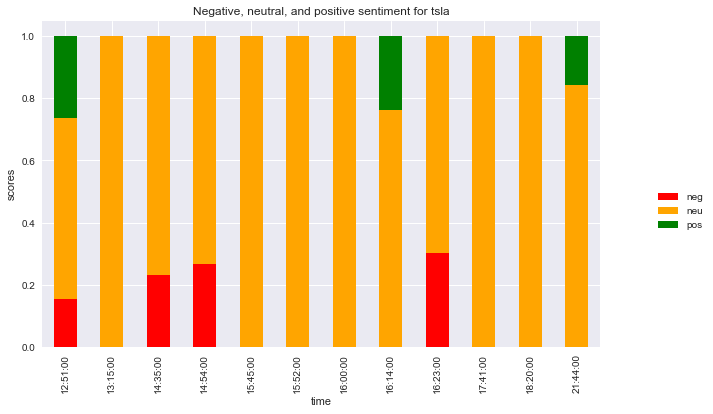

In [154]:
# assign plot title 
TITLE = "Negative, neutral, and positive sentiment for {}".format(ticker)
# assign colors to sentiment
COLORS = ["red","orange",'green']
# drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], 1)
# plot a stacked bar chart
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores")
plt.savefig('daysentiment.png')